In [60]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
from utility import prob_clip, weighted_theta_est
from linearBandit import LinBandit

In [75]:
## option: sample x and e from a known discrete distribution
x_dict = [0, -1]  ## true context uniformly drawn from this distribution
e_dict = {}
multiplier = 1
e_dict[0] = {"e": [1 * multiplier, -2 * multiplier], "p": [2/3, 1/3]}
e_dict[-1] = {"e": [-1 * multiplier, 2 * multiplier], "p": [2/3, 1/3]}

Sigma_e = (2./3 * 1 + 1./3 * 4) * (multiplier**2)

def generate_x_tilde_list(T, x_dict = x_dict, e_dict = e_dict, d = 1):
    x_list = np.zeros((T, d)) 
    x_tilde_list = np.zeros((T, d)) 
    for t in range(T):
        x_idx = np.random.randint(0, 2)
        x_t = x_dict[x_idx]
        e_list = e_dict[x_t]["e"]        ## list of possible values for e_t
        e_prob = e_dict[x_t]["p"]
        e_t = np.random.choice(e_list, p = e_prob)
        x_tilde_t = x_t + e_t
        x_list[t, :] = x_t
        x_tilde_list[t, :] = x_tilde_t
    return x_list, x_tilde_list

In [76]:
T = 10000
d = 1
n_experiment = 100
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([-3.])
theta[:, 1] = np.array([-2])
sigma = 0.000
p_0 = 0.1
pi_nd = np.array([0.5, 0.5])

In [77]:
## simulation: test bandit behavior policy
algorithms = ['UCB', 'TS', 'MEB']
theta_est = {}
for algorithm in algorithms:
    theta_est[algorithm] = np.zeros((n_experiment, n_action, T, d))        ## records the running theta estimation for each trajectory

pi_list = {}
for algorithm in algorithms:
    pi_list[algorithm] = np.zeros((n_experiment, T, n_action))    ## records the running action selection probability for each trajectory

theta_est_batch = {}
for algorithm in algorithms:
    theta_est_batch[algorithm] = np.zeros((n_experiment, n_action, d))        ## records the value of weighted theta estimation for each trajectory


In [78]:
for i_experiment in range(n_experiment):
    if (i_experiment % 10 == 0):
        print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    
    # generate x_t and x_t_tilde
    x_list, x_tilde_list = generate_x_tilde_list(T)
    
    # generate potential outcomes table
    Bandit_info = Bandit_1.generate_potential_reward_history_list_w_xtilde(x_list = x_list, \
                                                                           x_tilde_list = x_tilde_list)
    
    # run bandit algorithms
    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(
        x_list = x_list,
        x_tilde_list = x_tilde_list, 
        potential_reward_list = Bandit_info['potential_reward_list'], 
        at_dag_list = Bandit_info['at_dag_list'], 
        C = C, l = 1., p_0 = p_0, 
        x_tilde_test = np.array([-1.]))
    # TS_history = Bandit_1.TS_w_predicted_state(
    #     x_list = x_list,
    #     x_tilde_list = x_tilde_list, 
    #     potential_reward_list = Bandit_info['potential_reward_list'], 
    #     at_dag_list = Bandit_info['at_dag_list'], 
    #     rho2 = sigma ** 2, l = 1., p_0 = p_0, 
    #     x_tilde_test = np.array([-1.]))
    TS_history = Bandit_1.random_policy(x_list = x_list, x_tilde_list = x_tilde_list, potential_reward_list = Bandit_info['potential_reward_list'], at_dag_list = Bandit_info['at_dag_list'], x_tilde_test = np.array([-1.]))
    
    ## construct parameters for MEB
    ind_S = (np.arange(T) > 100)
    pi_nd_list = 0.5 * np.ones((T, n_action))
    Sigma_e_hat_list = np.zeros((T, d, d))
    for t in range(T):
        Sigma_e_hat_list[t, :, :] = Sigma_e
    MEB_history = Bandit_1.online_me_adjust_w_predicted_state(
        x_list = x_list, 
        x_tilde_list = x_tilde_list, 
        potential_reward_list = Bandit_info['potential_reward_list'],  
        at_dag_list = Bandit_info['at_dag_list'],
        Sigma_e_hat_list = Sigma_e_hat_list, 
        ind_S = ind_S, 
        pi_nd_list = pi_nd_list, 
        p_0 = p_0, 
        naive = False, 
        x_tilde_test = np.array([-1.]))
    
    # record running theta est
    theta_est["UCB"][i_experiment, :, :, :] = UCB_history['theta_est_list'][:, :, :]
    # theta_est["TS"][i_experiment, :, :, :] = TS_history['theta_est_list'][:, :, :]
    theta_est["TS"][i_experiment, :, :, :] = np.zeros((n_action, T, d))
    theta_est["MEB"][i_experiment, :, :, :] = MEB_history['theta_est_list'][:, :, :]
    
    # record action selection probability 
    pi_list["UCB"][i_experiment, :, :] = UCB_history['pi_list_test']
    pi_list["TS"][i_experiment, :, :] = TS_history['pi_list_test']
    pi_list["MEB"][i_experiment, :, :] = MEB_history['pi_list_test']
    
    # get weighted_theta_est
    theta_est_UCB_results = weighted_theta_est(history = UCB_history, \
                                               pi_nd = pi_nd, \
                                               Sigma_e = Sigma_e)
    theta_est_batch["UCB"][i_experiment, :, :] = theta_est_UCB_results
    theta_est_TS_results = weighted_theta_est(history = TS_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch["TS"][i_experiment, :, :] = theta_est_TS_results
    theta_est_MEB_results = weighted_theta_est(history = MEB_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch["MEB"][i_experiment, :, :] = theta_est_MEB_results


means_pi0 = {}
ses_pi0 = {}
for algorithm in algorithms:
    means_pi0[algorithm] = np.mean(pi_list[algorithm][:, :, 0], axis=0)
    ses_pi0[algorithm] = np.std(pi_list[algorithm][:, :, 0], axis=0) #/ np.sqrt(n_experiment)


0 10 20 30 40 50 60 70 80 90 

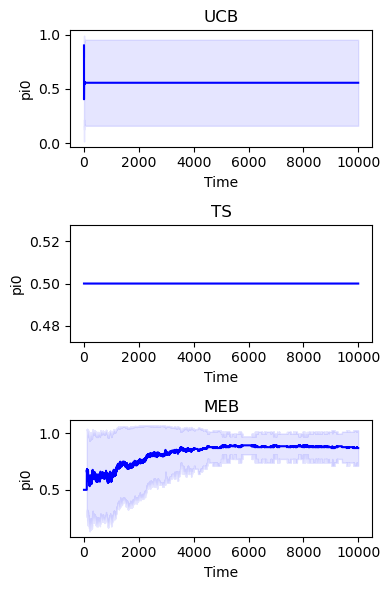

In [79]:


# Plot mean and se of the estimated theta0 for all the algorithms
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

for i_algorithm, algorithm in enumerate(algorithms):

# Plot for UCB
    axes[i_algorithm].plot(np.arange(1, T+1), means_pi0[algorithm][:], color='blue', alpha=1, label='Mean')
    axes[i_algorithm].fill_between(np.arange(1, T+1), means_pi0[algorithm][:] - ses_pi0[algorithm][:], \
                                     means_pi0[algorithm][:] + ses_pi0[algorithm][:], color='blue', alpha=0.1)
    axes[i_algorithm].set_title(algorithm)
    axes[i_algorithm].set_xlabel('Time')
    axes[i_algorithm].set_ylabel('pi0')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

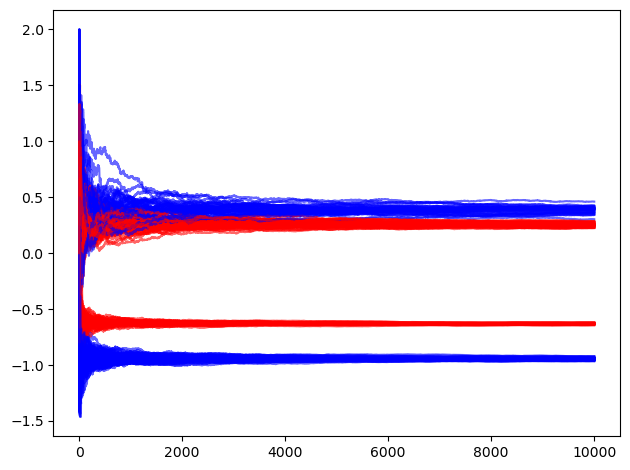

In [80]:
# Plot mean and se of the estimated theta0 for all the algorithms
fig= plt.plot(figsize=(4, 6))
for i_experiment in range(n_experiment):
    plt.plot(np.arange(1, T+1), theta_est["UCB"][i_experiment, 0, :, 0], color='blue', alpha=0.6)
    plt.plot(np.arange(1, T+1), theta_est["UCB"][i_experiment, 1, :, 0], color='red', alpha=0.6)
# Adjust layout for better spacing
plt.tight_layout()
# plt.ylim(0.69, 0.71)

# Show the plot
plt.show()

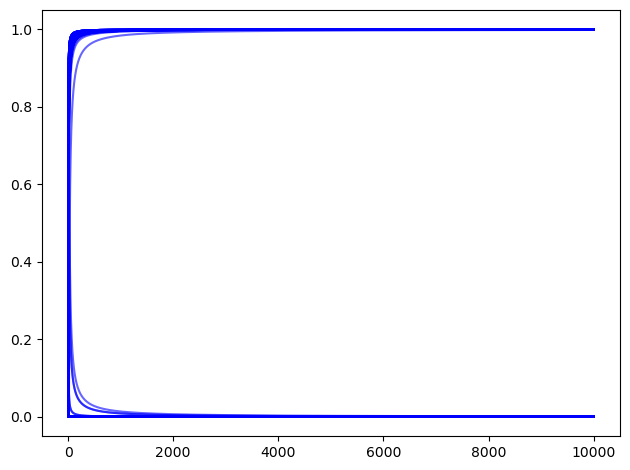

In [81]:
# Plot mean and se of the estimated theta0 for all the algorithms
fig= plt.plot(figsize=(4, 6))
for i_experiment in range(n_experiment):
    plt.plot(np.arange(1, T+1), np.cumsum((theta_est["UCB"][i_experiment, 0, :, 0] > theta_est["UCB"][i_experiment, 1, :, 0]).astype(int))/np.arange(1, T+1), color='blue', alpha=0.6)
# Adjust layout for better spacing
plt.tight_layout()
# plt.ylim(0.69, 0.71)

# Show the plot
plt.show()

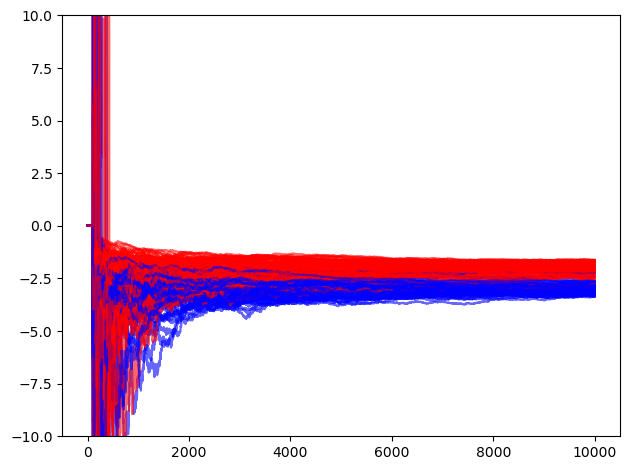

In [82]:
# Plot mean and se of the estimated theta0 for all the algorithms
fig= plt.plot(figsize=(4, 6))
for i_experiment in range(n_experiment):
    plt.plot(np.arange(1, T+1), theta_est["MEB"][i_experiment, 0, :, 0], color='blue', alpha=0.6)
    plt.plot(np.arange(1, T+1), theta_est["MEB"][i_experiment, 1, :, 0], color='red', alpha=0.6)

plt.ylim(-10, 10)
# Adjust layout for better spacing
plt.tight_layout()


# Show the plot
plt.show()

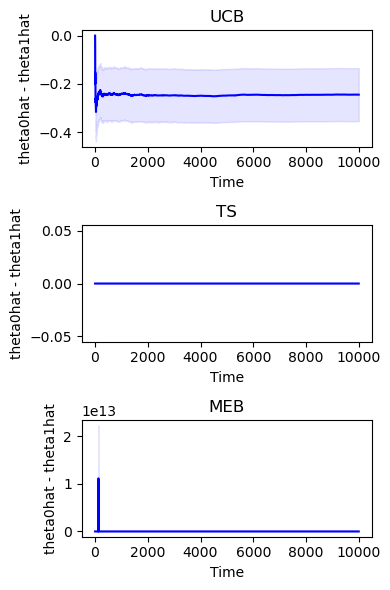

In [83]:

theta01_est = {}
for algorithm in algorithms:
    theta01_est[algorithm] = theta_est[algorithm][:, 0, :, 0] - theta_est[algorithm][:, 1, :, 0]        ## extract estimator of theta0-theta1 (first entry) over time for trajectories

means_theta01 = {}
ses_theta01 = {}
for algorithm in algorithms:
    means_theta01[algorithm] = np.mean(theta01_est[algorithm], axis=0)
    ses_theta01[algorithm] = np.std(theta01_est[algorithm], axis=0) / np.sqrt(n_experiment)

# Plot mean and se of the estimated theta0 for all the algorithms
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

for i_algorithm, algorithm in enumerate(algorithms):
    axes[i_algorithm].plot(np.arange(1, T+1), means_theta01[algorithm][:], color='blue', alpha=1, label='Mean')
    axes[i_algorithm].fill_between(np.arange(1, T+1), means_theta01[algorithm][:] - ses_theta01[algorithm][:], \
                                     means_theta01[algorithm][:] + ses_theta01[algorithm][:], color='blue', alpha=0.1)
    axes[i_algorithm].set_title(algorithm)
    axes[i_algorithm].set_xlabel('Time')
    axes[i_algorithm].set_ylabel('theta0hat - theta1hat')
    # axes[i_algorithm].set_ylim(-2, 0.25)


# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [84]:
# record weighted_theta_est for theta_0/theta_1
theta_0_est_batch = {}
for algorithm in algorithms:
    theta_0_est_batch[algorithm] = theta_est_batch[algorithm][:, 0, :]
for algorithm in algorithms:
    print('Sample Mean and Cov of weighted theta estimators, data collected by ' + algorithm + ':')
    print(np.mean(theta_0_est_batch[algorithm], axis=0)[0], np.cov(theta_0_est_batch[algorithm], rowvar=False))

Sample Mean and Cov of weighted theta estimators, data collected by UCB:
-3.0065580888631223 0.01879058970805804
Sample Mean and Cov of weighted theta estimators, data collected by TS:
-2.9939368631051315 0.007250058312697157
Sample Mean and Cov of weighted theta estimators, data collected by MEB:
-2.988231792693654 0.013146868145869366


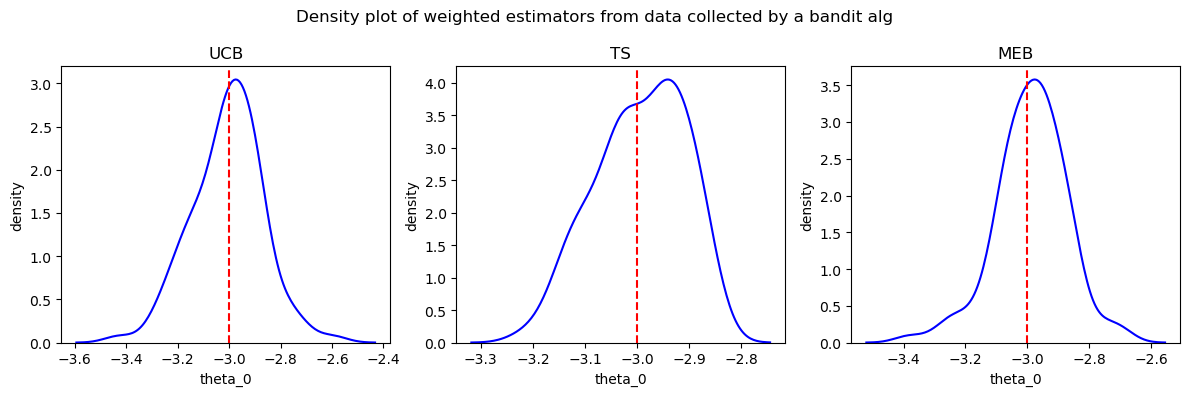

In [86]:
# draw histogram of weighted_theta_est
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: density plot for UCB batch estimates
for i_algorithm, algorithm in enumerate(algorithms):
    sns.kdeplot(theta_0_est_batch[algorithm][:, 0], color="Blue", ax=axes[i_algorithm])
    axes[i_algorithm].set_xlabel('theta_0')  # Set X axis label for first plot
    axes[i_algorithm].set_ylabel('density')  # Set Y axis label for first plot
    axes[i_algorithm].set_title(algorithm)
    # Add vertical line at x=-3
    axes[i_algorithm].axvline(x=-3, color='red', linestyle='--')

# Set same x and y axis limits for all subplots
# x_limits = (-3.5, -2.5)  # Define x-axis limits
# y_limits = (-0.15, 6)  # Define y-axis limits

# for ax in axes:
#     ax.set_xlim(x_limits)  # Set x-axis range
#     ax.set_ylim(y_limits)  # Set y-axis range

# Add overall title and show the plots
plt.suptitle('Density plot of weighted estimators from data collected by a bandit alg')
plt.tight_layout()
plt.show()

simulation for 2d linear contextual bandit, test theta distribution

In [140]:
## simulation: test bandit behavior policy

T = 1000
d = 2
n_experiment = 1000
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([1., 0])
theta[:, 1] = np.array([1., 0])
sigma = 0.01
p_0 = 0.2
pi_nd = np.array([0.5, 0.5])

## option: sample x and e from a known discrete distribution
x_dict = np.array([[1., -3, -1, 3],[3, 1, -3, -1]]).T  ## true context uniformly drawn from this distribution
#x_dict = np.array([[0., -3, 0, 3],[3, 0, -3, 0]]).T  ## true context uniformly drawn from this distribution
l_e = 2.      ## scale parameter of the contextual noise
e_dict = l_e * np.array([[1., -1],[1, -1]]).T  ## contextual noise uniformly drawn from this distribution
Sigma_e = l_e ** 2 * np.array([[1., 1],[1, 1]])


theta_est_batch_UCB = np.zeros((n_experiment, n_action, d))
theta_est_batch_TS = np.zeros((n_experiment, n_action, d))
theta_est_batch_MEB = np.zeros((n_experiment, n_action, d))
for i_experiment in range(n_experiment):
    if (i_experiment % 10 == 0):
        print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    
    # generate x_t and x_t_tilde
    x_list = np.zeros((T, d)) 
    x_tilde_list = np.zeros((T, d)) 
    for t in range(T):
        ## option: sample x and e from a known discrete distribution
        x_idx = np.random.randint(0, 4)
        x_t = x_dict[x_idx, :]
        e_idx = np.random.randint(0, 2)
        e_t = e_dict[e_idx, :]
        x_tilde_t = x_t + e_t
        x_list[t, :] = x_t
        x_tilde_list[t, :] = x_tilde_t
    
    # generate potential outcomes table
    Bandit_info = Bandit_1.generate_potential_reward_history_list_w_xtilde(x_list = x_list, \
                                                                           x_tilde_list = x_tilde_list)
    
    # run bandit algorithms
    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = x_tilde_list, \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0)
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = x_tilde_list, \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0)
    
    ## construct parameters for MEB
    ind_S = (np.arange(T) > 100)
    pi_nd_list = 0.5 * np.ones((T, n_action))
    Sigma_e_hat_list = np.zeros((T, d, d))
    for t in range(T):
        Sigma_e_hat_list[t, :, :] = Sigma_e
    MEB_history = Bandit_1.online_me_adjust_w_predicted_state(x_list = x_list, x_tilde_list = x_tilde_list, \
                                                              potential_reward_list = Bandit_info['potential_reward_list'],  
                                                              at_dag_list = Bandit_info['at_dag_list'],\
                                                              Sigma_e_hat_list = Sigma_e_hat_list, \
                                                              ind_S = ind_S, 
                                                              pi_nd_list = pi_nd_list, \
                                                              p_0 = p_0, naive = False)
    
    # get weighted_theta_est
    theta_est_UCB_results = weighted_theta_est(history = UCB_history, \
                                               pi_nd = pi_nd, \
                                               Sigma_e = Sigma_e)
    theta_est_batch_UCB[i_experiment, :, :] = theta_est_UCB_results['theta_est_batch']
    theta_est_TS_results = weighted_theta_est(history = TS_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_TS[i_experiment, :, :] = theta_est_TS_results['theta_est_batch']
    theta_est_MEB_results = weighted_theta_est(history = MEB_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_MEB[i_experiment, :, :] = theta_est_MEB_results['theta_est_batch']


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

In [141]:
# record weighted_theta_est for theta_0/theta_1
theta_0_est_batch_UCB = theta_est_batch_UCB[:, 0, :]
theta_0_est_batch_TS = theta_est_batch_TS[:, 0, :]
theta_0_est_batch_MEB = theta_est_batch_MEB[:, 0, :]

In [142]:
np.max(theta_0_est_batch_UCB)

1.217337189350267

In [143]:
print('Sample Cov of weighted theta estimators, data collected by UCB:')
print(np.cov(theta_0_est_batch_UCB, rowvar=False))
print('Sample Cov of weighted theta estimators, data collected by TS:')
print(np.cov(theta_0_est_batch_TS, rowvar=False))
print('Sample Cov of weighted theta estimators, data collected by MEB:')
print(np.cov(theta_0_est_batch_MEB, rowvar=False))

Sample Cov of weighted theta estimators, data collected by UCB:
[[0.00310743 0.000383  ]
 [0.000383   0.00273987]]
Sample Cov of weighted theta estimators, data collected by TS:
[[0.00289376 0.0002411 ]
 [0.0002411  0.00270733]]
Sample Cov of weighted theta estimators, data collected by MEB:
[[0.00285658 0.00025073]
 [0.00025073 0.00263663]]


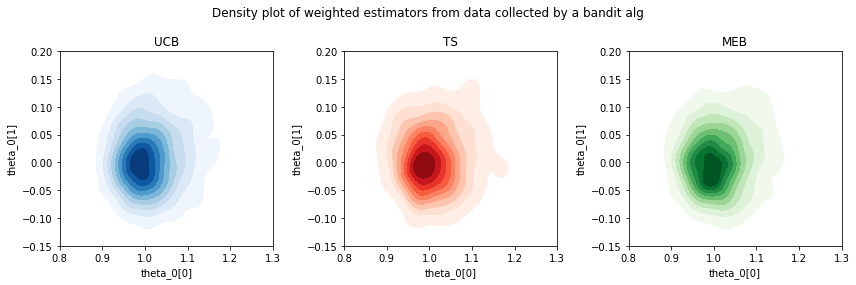

In [144]:
# draw histogram of weighted_theta_est
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: 2D density plot for UCB batch estimates
sns.kdeplot(x=theta_0_est_batch_UCB[:, 0], y=theta_0_est_batch_UCB[:, 1], fill=True, cmap="Blues", ax=axes[0])
axes[0].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[0].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[0].set_title('UCB')

# Second subplot: 2D density plot for TS batch estimates
sns.kdeplot(x=theta_0_est_batch_TS[:, 0], y=theta_0_est_batch_TS[:, 1], fill=True, cmap="Reds", ax=axes[1])
axes[1].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[1].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[1].set_title('TS')

# 3rd subplot: 2D density plot for MEB batch estimates
sns.kdeplot(x=theta_0_est_batch_MEB[:, 0], y=theta_0_est_batch_MEB[:, 1], fill=True, cmap="Greens", ax=axes[2])
axes[2].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[2].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[2].set_title('MEB')

# Set same x and y axis limits for all subplots
x_limits = (0.8, 1.3)  # Define x-axis limits
y_limits = (-0.15, 0.2)  # Define y-axis limits

for ax in axes:
    ax.set_xlim(x_limits)  # Set x-axis range
    ax.set_ylim(y_limits)  # Set y-axis range

# Add overall title and show the plots
plt.suptitle('Density plot of weighted estimators from data collected by a bandit alg')
plt.tight_layout()
plt.show()

A counterexample where naive UCB and TS leads to linear regret, even Ass. 2.3 is satisfied

In [5]:
## simulation: construct bandit instance, compare estimation and regret of proposed algorithm and TS
T = 10000
d = 2
n_experiment = 100
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([1., 0])
theta[:, 1] = np.array([-1., 0])
sigma = 0.01
#Sigma_e = 1./4 * np.eye(d) ## not used
#Sigma_e_list = np.zeros((T, d, d)) ## not used
#for t in range(T):
#    Sigma_e_list[t, :, :] = Sigma_e
p_0 = 0.2

UCB_estimation_err_sum = np.zeros((T, n_action))
UCB_estimation_err_sum2 = np.zeros((T, n_action))
UCB_regret_err_sum = np.zeros(T)
UCB_regret_err_sum2 = np.zeros(T)
TS_estimation_err_sum = np.zeros((T, n_action))
TS_estimation_err_sum2 = np.zeros((T, n_action))
TS_regret_err_sum = np.zeros(T)
TS_regret_err_sum2 = np.zeros(T)

x_dict = np.array([[1, -3, -1, 3],[3, 1, -3, -1]]).T

for i_experiment in range(n_experiment):
    print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    ## iid x_t
    x_list = np.zeros((T, d)) 
    for t in range(T):
        x_idx = np.random.randint(0, 4)
        x_list[t, :] = x_dict[x_idx, :]
    
    Bandit_info = Bandit_1.generate_potential_reward_history_list1(x_list = x_list, rho = 0.9)
    #print('data generated')

    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = Bandit_info['x_tilde_list'], \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0)
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = Bandit_info['x_tilde_list'], \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0)
    
    UCB_estimation_err_sum = UCB_estimation_err_sum + UCB_history['estimation_err_list']
    UCB_estimation_err_sum2 = UCB_estimation_err_sum2 + UCB_history['estimation_err_list'] ** 2
    UCB_regret_err_sum = UCB_regret_err_sum + UCB_history['regret_list']
    UCB_regret_err_sum2 = UCB_regret_err_sum2 + UCB_history['regret_list'] ** 2
    TS_estimation_err_sum = TS_estimation_err_sum + TS_history['estimation_err_list']
    TS_estimation_err_sum2 = TS_estimation_err_sum2 + TS_history['estimation_err_list'] ** 2
    TS_regret_err_sum = TS_regret_err_sum + TS_history['regret_list']
    TS_regret_err_sum2 = TS_regret_err_sum2 + TS_history['regret_list'] ** 2

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [6]:
UCB_history['theta_est_list'][0, :, :] - UCB_history['theta_est_list'][1, :, :]

array([[ 0.        ,  0.        ],
       [ 0.06118129, -0.75456921],
       [ 0.12231343, -1.50853228],
       ...,
       [ 1.3782704 , -0.611232  ],
       [ 1.37827362, -0.61116096],
       [ 1.37823703, -0.61107253]])

In [7]:
UCB_estimation_err_sum.shape

(10000, 2)

(0.0, 1.0)

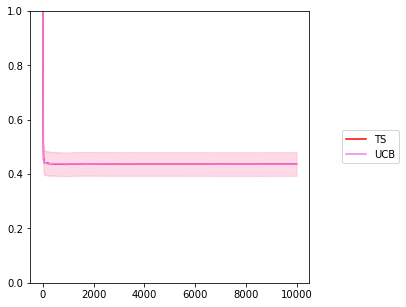

In [9]:
# plot estimation error (theta_1)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_1_mean = TS_estimation_err_sum[:, 1] / n_experiment
TS_est_1_sd = (TS_estimation_err_sum2[:, 1] - TS_est_1_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_1_mean = UCB_estimation_err_sum[:, 1] / n_experiment
UCB_est_1_sd = (UCB_estimation_err_sum2[:, 1] - UCB_est_1_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_1_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_1_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_1_mean - TS_est_1_sd, \
                TS_est_1_mean + TS_est_1_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_1_mean - UCB_est_1_sd, \
                UCB_est_1_mean + UCB_est_1_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")

(0.0, 1.0)

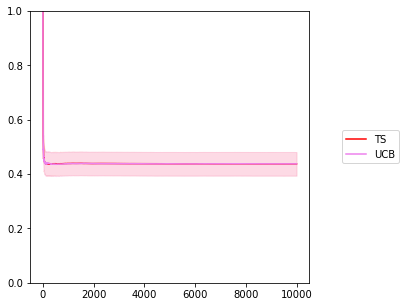

In [10]:
# plot estimation error (theta_0)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_0_mean = TS_estimation_err_sum[:, 0] / n_experiment
TS_est_0_sd = (TS_estimation_err_sum2[:, 0] - TS_est_0_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_0_mean = UCB_estimation_err_sum[:, 0] / n_experiment
UCB_est_0_sd = (UCB_estimation_err_sum2[:, 0] - UCB_est_0_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_0_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_0_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_0_mean - TS_est_0_sd, \
                TS_est_0_mean + TS_est_0_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_0_mean - UCB_est_0_sd, \
                UCB_est_0_mean + UCB_est_0_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")

In [11]:
TS_est_0_mean

array([1.        , 0.9856095 , 0.95660385, ..., 0.43754418, 0.43754841,
       0.43755095])

In [12]:
TS_est_1_mean

array([1.        , 0.92636405, 0.87044548, ..., 0.43692377, 0.4369183 ,
       0.43691462])

(0.0, 6000.0)

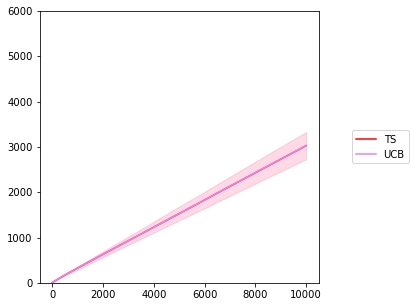

In [13]:
# plot regret
fig, ax = plt.subplots(figsize=(5, 5))
UCB_regret_mean = UCB_regret_err_sum / n_experiment
UCB_regret_sd = (UCB_regret_err_sum2 - UCB_regret_mean ** 2) ** 0.5 / (n_experiment)
TS_regret_mean = TS_regret_err_sum / n_experiment
TS_regret_sd = (TS_regret_err_sum2 - TS_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_regret_mean = ME_regret_err_sum / n_experiment
#ME_regret_sd = (ME_regret_err_sum2 - ME_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_n_regret_mean = ME_n_regret_err_sum / n_experiment
#ME_n_regret_sd = (ME_n_regret_err_sum2 - ME_n_regret_mean ** 2) ** 0.5 / (n_experiment)
#ax.plot(np.arange(T), ME_regret_err_sum / n_experiment, color = 'blue', markersize=0.2, label = 'MEB')
#ax.plot(np.arange(T), ME_n_regret_err_sum / n_experiment, color = 'green', markersize=0.2, label = 'MEB_naive')
ax.plot(np.arange(T), TS_regret_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_regret_mean, color = 'violet', markersize=0.2, label = 'UCB')
#ax.fill_between(np.arange(T), ME_regret_mean - ME_regret_sd, \
#                ME_regret_mean + ME_regret_sd, color = 'blue', alpha=0.1)
#ax.fill_between(np.arange(T), ME_n_regret_mean - ME_n_regret_sd, \
#                ME_n_regret_mean + ME_n_regret_sd, color = 'green', alpha=0.1)
ax.fill_between(np.arange(T), TS_regret_mean - TS_regret_sd, \
                TS_regret_mean + TS_regret_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_regret_mean - UCB_regret_sd, \
                UCB_regret_mean + UCB_regret_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 20000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.set_ylim([0, 6000])
#fig.savefig("8.pdf", format="pdf")

In [17]:
np.mean(UCB_history['at_list'] != UCB_history['at_dag_list'])

0.05725885482290354

In [18]:
print(TS_est_1_mean[-1], TS_est_1_sd[-1])
print(ME_est_1_mean[-1], ME_est_1_sd[-1])
print(ME_n_est_1_mean[-1], ME_n_est_1_sd[-1])

0.00953130966478182 0.0030226257632393547
0.001432803780325856 0.00046066716311827475
0.004916243975077221 0.0015896085612874683


In [19]:
print(TS_regret_mean[-1], TS_regret_sd[-1])
print(ME_regret_mean[-1], ME_regret_sd[-1])
print(ME_n_regret_mean[-1], ME_n_regret_sd[-1])

1.4970634701129981 0.48050701951340796
2.6064130978591264 0.8423614527617207
6.836600049914643 2.2154570557423474
